$\Huge Code$ $\hspace{0.1cm}$ $\Huge to$ $\hspace{0.1cm}$ $\Huge simulate$ $\hspace{0.1cm}$ $\Huge the$ $\hspace{0.1cm}$ $\Huge atmosphere$ $\hspace{0.1cm}$ $\Huge :$ 

# Modules : 

In [1]:
%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt 
from matplotlib import rc
rc('text', usetex=True)
from astropy.io import fits
import numpy as np
from astropy import constants as cst
from astropy.cosmology import FlatLambdaCDM
import pysm as pysm
import ccatp_sky_model as sky
from tqdm import tqdm 

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.7255)
T_CMB = cosmo.Tcmb0.si.value
k_B = cst.k_B.value
h = cst.h.value
c = cst.c.value

In [3]:
data_path = "/vol/arc3/data1/sz/CCATp_sky_model/templates/"

# Function : 

In [4]:
def simulate_atmosphere(freq, nside_out = 4096, lmax = None, beam_FWHM = None, unit = 'cmb', no_white = False):

    '''Computes an all-sky atmospheric noise map at a given frequency and nside based on 
    the SO noise model presented by the SO Collaboration (2019) and using the model parameters
    provided by Choi et al. (2019). 
    Parameters
    ----------
    freq: float or float array
        Frequency of the output map in Hz. Must be a valid SO or CCAT-prime central
        band frequency, i.e. 27, 39, 93, 145, 225, 279, 220, 280, 350, 405, or 860 GHz.
    nside_out: float, optional
        Healpix nside parameter of the output map. Must be a valid value for nside.
        Default: 4096
    lmax: float, optional
        Maximum value of the multipolemoment at which the atmospheric power spectrum
        wil be computed. Default: 3*nside_out-1    
    beam_FWHM: bool, optional
        If set, the output will be convolved with a gaussian. The FWHM of the Gaussian
        in units of arcmin is given by the provided value. Default: None
    unit: bool, optional
        Determines the units of the output map. The available units are 'mjy' --> MJy/sr
        (specific intensity), 'cmb' --> K_CMB (thermodynamic temperature), and 
        'rj' --> K_RJ (brightness temperature). Default: 'cmb'.
    no_white: bool, optional
        If True, only the red noise component is simulated. Default: False
    Returns
    -------
    noise_map: float array
        Healpix all-sky map of the atmospheric noise at the specified frequency.
    '''

    if lmax is None:
        lmax = 3*nside_out-1

    #Define frequencies and noise characteristics of the SO and CCAT-prime
    nu = np.array([27, 39, 93, 145, 225, 279, 220, 280, 350, 405, 860])*1e9
    N_white = np.array([2.351167E-04, 6.414462E-05, 2.975014E-06, 3.458125E-06, 2.011171E-05, 1.272230E-04, 1.8e-5, 6.4e-5, 9.3e-4, 1.2e-2, 2.8e4])
    N_red = np.array([9.248376E-06, 2.236786E-06, 2.622661E-05, 3.298953E-04, 1.462620E-02, 8.579506E-02, 1.6e-2, 1.1e-1, 2.7e0, 1.7e1, 6.1e6])
    ell_knee = 1000 
    alpha_knee = -3.5
    
    #Check if input frequency is a valid SO or CCAT-prime central band frequency
    index = freq == nu
    if np.sum(index) == 0:

        print('Warning: Input frequency is not a valid SO or CCAT-prime band. Try 27, 39, 93, 145, 225, 279, 220, 280, 350, 405, or 860 GHz')
        return(None)

    else:

        #Compute power spectrum
        ell = np.linspace(1,lmax,lmax)
        Cl = N_red[index] * (ell/ell_knee)**alpha_knee 
 
        if no_white is True:
            Cl += N_white[index]

        #Create all-sky map
        noise_map = hp.sphtfunc.synfast(Cl, nside_out, lmax=lmax)/1e6

        #Convert units if necessary
        if unit == 'mjy':
            noise_map = convert_units(freq, noise_map, cmb2mjy=True)
        elif unit == 'cmb':
            None
        elif unit == 'rj':
            noise_map = convert_units(freq, noise_map, cmb2rj=True)
        else:
            print('Waring: Unknown unit! Output will be in K_CMB')

        #Return output
        return(np.float32(noise_map))


# Launch : 

In [6]:
map_atmo = simulate_atmosphere(freq=350e9, nside_out = 1024, lmax = None, beam_FWHM = None, unit = 'cmb',
                               no_white = False)

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:395: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


masked_array(
  data=[[-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],
  mask=False,
  fill_value=-1.6375e+30)

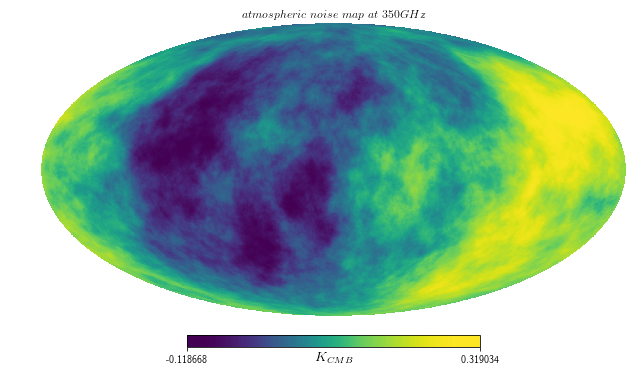

In [7]:
hp.mollview(map=map_atmo, coord=None, nest=False, title='$atmospheric$ $noise$ $map$ $at$ $350GHz$',
            unit='$K_{CMB}$', norm='hist', xsize=2000,return_projected_map=True)